In [1]:
# Python 3.9.18
# Numpy : 1.26.0
# Pandas : 2.1.1
# Matplotlib : 3.7.2
# Seaborn : 0.12.2
# Scikit-learn : 1.3.0
# Created: OCT. 25. 2023
# Author: D.W. SHIN
# 2023 전력사용량 예측 AI 경진대회
# 알고리즘 | 정형 | 시계열 | 에너지 | SMAPE
# [Baseline] Random Forest을 기본으로 사용함

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import platform

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pycaret.regression import *

from sklearn.linear_model import LinearRegression, SGDRegressor, ARDRegression, GammaRegressor, PoissonRegressor, TweedieRegressor, HuberRegressor, QuantileRegressor, RANSACRegressor, ridge_regression, TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor
# from xgboost import XGBRegressor as xgb
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
sysOS = platform.system()

if sysOS == 'Windows':
    # Windows 일 경우
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
elif sysOS == 'Darwin':
    # Mac일 경우
    plt.rcParams['font.family'] ='AppleGothic'
    plt.rcParams['axes.unicode_minus'] = False
else:
    print('Please check your Korean font!!')
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    print('#' * 30)
    print('#' * 30)
    print('런타임을 다시 시작해 주세요~~~')
    print('#' * 30)
    print('#' * 30)

## Fixed Random-Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [4]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_info.csv')

In [ ]:
train_df.info()

In [ ]:
train_df.tail()

In [ ]:
building_df.info()

In [ ]:
building_df.tail()

## Train Data Pre-Processing

### 날짜 컬럼 생성

In [5]:
#'일시' 컬럼을 날짜 컬럼으로 추가
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['YEAR'] = train_df['일시'].dt.year
train_df['MONTH'] = train_df['일시'].dt.month
train_df['DAY'] = train_df['일시'].dt.day
train_df['DATE'] = train_df['일시'].dt.date
train_df['HOUR'] = train_df['일시'].dt.hour
train_df['WEEKDAY'] = train_df['일시'].dt.weekday

### 결측치 처리

In [ ]:
# 결측값이 있는지 확인
train_df.isna().sum()

In [6]:
# 강수량(mm)의 결측치는 너무 많아서 0으로 처리 함
train_df['강수량(mm)'].fillna(0, inplace=True)

In [7]:
# 풍속(m/s)의 결측치를 확인
train_df[train_df['풍속(m/s)'].isnull()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DATE,HOUR,WEEKDAY
16643,9_20220614 11,9,2022-06-14 11:00:00,17.6,0.0,NaN,NaN,NaN,NaN,2330.40,2022,6,14,2022-06-14,11,1
30161,15_20220806 17,15,2022-08-06 17:00:00,35.6,0.0,NaN,NaN,NaN,NaN,1815.57,2022,8,6,2022-08-06,17,5
32127,16_20220803 15,16,2022-08-03 15:00:00,30.4,0.0,NaN,77.0,0.5,2.06,5062.08,2022,8,3,2022-08-03,15,2
51640,26_20220627 16,26,2022-06-27 16:00:00,27.2,3.1,NaN,93.0,0.0,0.27,5330.40,2022,6,27,2022-06-27,16,0
51921,26_20220709 09,26,2022-07-09 09:00:00,26.3,0.0,NaN,84.0,0.0,0.81,2908.80,2022,7,9,2022-07-09,9,5
84418,42_20220703 10,42,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3038.76,2022,7,3,2022-07-03,10,6
100738,50_20220703 10,50,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3044.70,2022,7,3,2022-07-03,10,6
105639,52_20220806 15,52,2022-08-06 15:00:00,33.4,0.0,NaN,72.0,0.0,NaN,2260.20,2022,8,6,2022-08-06,15,5
105640,52_20220806 16,52,2022-08-06 16:00:00,33.5,0.0,NaN,73.0,0.0,NaN,2274.30,2022,8,6,2022-08-06,16,5
176477,87_20220714 05,87,2022-07-14 05:00:00,21.9,0.0,NaN,NaN,NaN,NaN,519.66,2022,7,14,2022-07-14,5,3


In [8]:
# 샘플 조건 테스트
train_df[(train_df['건물번호'] == 9) & (train_df['MONTH'] == 6) & (train_df['HOUR'] == 11)]['풍속(m/s)'].describe()['mean']

2.9413793103448276

In [9]:
# 풍속의 결측치를 건물의 동일 시간의 한달 평균으로 채워 넣는다.
for i in train_df[train_df['풍속(m/s)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & (train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['풍속(m/s)'].describe()['mean']
    train_df.loc[i, '풍속(m/s)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '풍속(m/s)'])

2.9413793103448276
2.1130434782608694
2.2782608695652176
2.0758620689655167
1.0800000000000003
1.6566666666666665
1.6566666666666665
4.569565217391304
4.621739130434783
0.4499999999999999
0.28666666666666674
0.4033333333333334
0.6599999999999999
0.63
2.1130434782608694
4.569565217391304
4.621739130434783
2.4793103448275864
0.41


In [10]:
train_df['풍속(m/s)'].isna().sum()

0

In [11]:
# 습도의 결측치도 동일하게 처리 한다
for i in train_df[train_df['습도(%)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & ( train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['습도(%)'].describe()['mean']
    train_df.loc[i, '습도(%)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '습도(%)'])

66.55172413793103
71.30434782608695
95.63333333333334
95.7
94.33333333333333
90.4
85.53333333333333
71.30434782608695
61.58620689655172


In [12]:
# 일조(hr)와 일사(MJ/m2)의 결측치를 0 으로 처리함
train_df['일조(hr)'].fillna(0, inplace=True)
train_df['일사(MJ/m2)'].fillna(0, inplace=True)

In [13]:
train_df.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
YEAR             0
MONTH            0
DAY              0
DATE             0
HOUR             0
WEEKDAY          0
dtype: int64

#### building info에서 결측치 '-'를 0으로 변경 후 컬럼의 속성을 float로 변경하는 방법 : 

##### 1. 느린방법

In [14]:
# 결측치가 '-' 를 확인
# building_df.isin(['-']).sum()

In [15]:
# 결측치 '-'를 0으로 채움
# building_df.replace('-', 0, inplace=True)

In [16]:
# building_df.isin(['-']).sum()

In [17]:
# 아래 컬럼의 속성을 float로 변환
# building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
# building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
# building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)

In [18]:
# building_df.info()

##### 2. 빠른방법

In [19]:
cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols:
    building_df[col] = building_df[col].apply(lambda x : 0 if x =='-' else float(x))

In [20]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


### 필요 컬럼 생성

#### 불쾌 지수 생성
- 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3


In [21]:
train_df['DI'] = 0.81 * train_df['기온(C)'] + 0.01 * train_df['습도(%)'] * (0.99 * train_df['기온(C)'] - 14.3) + 46.3

In [22]:
train_df['DI_CAT'] = pd.cut(train_df['DI'], bins=[0, 68, 78, 80, 100], include_lowest=True, labels=['GOOD', 'NOMAL', 'BAD', 'VERY_BAD'])

In [23]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DATE,HOUR,WEEKDAY,DI,DI_CAT
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.5,0.0,881.04,2022,8,24,2022-08-24,19,2,72.38034,NOMAL
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,798.96,2022,8,24,2022-08-24,20,2,71.21736,NOMAL
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,825.12,2022,8,24,2022-08-24,21,2,69.79704,NOMAL
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,640.08,2022,8,24,2022-08-24,22,2,69.41060,NOMAL
203999,100_20220824 23,100,2022-08-24 23:00:00,20.7,0.0,0.1,95.0,0.0,0.0,540.24,2022,8,24,2022-08-24,23,2,68.95035,NOMAL


### DF 합치기

In [24]:
# building_df을 train_df으로 데이터 프레임 합치기
train_df = pd.merge(train_df, building_df, how='left',on='건물번호')

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   건물번호           204000 non-null  int64         
 2   일시             204000 non-null  datetime64[ns]
 3   기온(C)          204000 non-null  float64       
 4   강수량(mm)        204000 non-null  float64       
 5   풍속(m/s)        204000 non-null  float64       
 6   습도(%)          204000 non-null  float64       
 7   일조(hr)         204000 non-null  float64       
 8   일사(MJ/m2)      204000 non-null  float64       
 9   전력소비량(kWh)     204000 non-null  float64       
 10  YEAR           204000 non-null  int64         
 11  MONTH          204000 non-null  int64         
 12  DAY            204000 non-null  int64         
 13  DATE           204000 non-null  object        
 14  HOUR           204000 non-null  int64         
 15  

### 컬럼 삭제

In [26]:
# 생성된 컬럼 중 분석에 필요하지 않은 컬럼 제거
train_df.drop(['num_date_time'], axis=1, inplace=True)

## 데이터 분석하기

In [ ]:
# 건물유형에 따른 전력소비량 확인하기
train_df.groupby('건물유형')['전력소비량(kWh)'].sum().sort_values(ascending=False)

In [ ]:
# 건물유형에 따른 전력소비량 그래프로 확인하기
plt.figure(figsize=(15,8))
sns.boxplot(x='건물유형', y='전력소비량(kWh)', data=train_df)
plt.show()

In [ ]:
train_df.info()

### 레이블 작업 하기

In [27]:
# 레이블링 작업
le = LabelEncoder()
train_df['DI_CAT'] = le.fit_transform(train_df['DI_CAT'])

### 건물 유형별 corr 확인

In [ ]:
#각 건물유형 별 corr 확인하기
building_infos = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

result_list = []
for index, building_info in enumerate(building_infos):
    result_df = train_df[train_df['건물유형'] == building_info]
    result_df = result_df.drop(['일시', 'DATE', 'HOUR', 'WEEKDAY', '건물유형'], axis=1)
    result_list.append(result_df.corr())


In [ ]:
result_list[0]

In [ ]:
result_list[0].iloc[:, 7]

In [ ]:
# corr 리스트로 담기
corr_list = []
for index, building_info in enumerate(building_infos):
    corr_list.append(result_list[index].iloc[:, 7])

In [ ]:
corr_list[0]

In [ ]:
# DF 만들기
corr_df = pd.DataFrame(corr_list)

In [ ]:
corr_df

In [ ]:
corr_df.index = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

In [ ]:
corr_df

## 레이블 작업 하기

In [ ]:
train_df.info()

In [28]:
# 레이블링 작업
le = LabelEncoder()
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])

In [ ]:
train_df.info()

In [29]:
# 컬럼 삭제
train_df.drop(['일시', 'DATE'], axis=1, inplace=True)

## 모델 선정하기

In [30]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(['전력소비량(kWh)'], axis=1), train_df['전력소비량(kWh)'], test_size=0.2, random_state=123)

In [31]:
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(train_df, train_df['전력소비량(kWh)'], test_size=0.2, random_state=123)

In [32]:
x_train_p.shape, x_test_p.shape

((163200, 21), (40800, 21))

In [33]:
x_train_p

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,...,HOUR,WEEKDAY,DI,DI_CAT,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
111385,55,22.6,0.0,1.3,99.0,0.0,0.00,929.52,2022,7,...,1,4,72.59926,2,6,25341.87,13040.10,0.0,0.0,0.0
120780,60,24.5,0.0,2.6,72.0,0.0,0.50,2083.20,2022,6,...,12,5,73.31260,2,6,188902.07,142187.28,365.0,0.0,0.0
90867,45,22.7,0.0,1.1,91.0,0.0,0.00,2242.08,2022,7,...,3,6,72.12443,2,5,86787.03,70579.00,0.0,0.0,0.0
84108,42,28.7,0.0,3.0,64.0,1.0,2.88,3098.88,2022,6,...,12,0,78.57932,0,4,97915.10,72000.00,0.0,0.0,0.0
144850,72,25.4,0.0,0.9,33.0,1.0,2.61,1049.94,2022,6,...,10,2,70.45318,2,8,31503.00,12667.00,95.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119906,59,27.9,0.0,2.1,85.0,0.0,0.00,654.12,2022,8,...,2,5,80.22185,3,6,105500.72,84402.00,0.0,0.0,0.0
192476,95,26.7,0.0,1.5,75.0,0.2,0.00,887.04,2022,6,...,20,3,77.02675,2,11,196992.54,57022.55,0.0,0.0,0.0
17730,9,32.1,0.0,2.6,62.0,1.0,1.10,3336.48,2022,7,...,18,4,83.13798,3,0,222882.35,15651.18,0.0,0.0,0.0
28030,14,24.5,0.7,5.4,97.0,0.0,0.00,2121.12,2022,8,...,22,1,75.80135,2,0,16844.16,14102.92,56.0,0.0,0.0


In [34]:
reg_model = setup(session_id=7,
                  data=x_train_p,
                  test_data=x_test_p,
                  target='전력소비량(kWh)',
                  normalize=True,
                  normalize_method='zscore', 
                  transformation=True,
                  fold_strategy='stratifiedkfold',
                  fold=5,
                  use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

,Description,Value
0,Session id,7
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 21)"
4,Transformed data shape,"(204000, 21)"
5,Transformed train set shape,"(163200, 21)"
6,Transformed test set shape,"(40800, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

In [35]:
models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1660 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
pycaret_reg_models = compare_models(n_select=13,
                                    sort='MAE',
                                    include=['gbr','lightgbm'])

In [36]:
best = compare_models()

In [91]:
pycaret_reg_models

[]

In [37]:
from pycaret.regression import *
s = setup(train_df, target = '전력소비량(kWh)', session_id = 123)

,Description,Value
0,Session id,123
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 21)"
4,Transformed data shape,"(204000, 21)"
5,Transformed train set shape,"(142800, 21)"
6,Transformed test set shape,"(61200, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


In [38]:
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

In [39]:
type(exp)

pycaret.regression.oop.RegressionExperiment

In [40]:
exp.setup(train_df, target = '전력소비량(kWh)', session_id = 123)

,Description,Value
0,Session id,123
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 21)"
4,Transformed data shape,"(204000, 21)"
5,Transformed train set shape,"(142800, 21)"
6,Transformed test set shape,"(61200, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


In [41]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,82.1961,25804.6366,160.5334,0.9957,0.0832,0.0451,7.7670
rf,Random Forest Regressor,87.8033,30715.1407,175.1331,0.9948,0.0868,0.0476,9.2810
dt,Decision Tree Regressor,112.7601,58843.5862,242.2886,0.9901,0.1186,0.0597,0.2110
xgboost,Extreme Gradient Boosting,175.6424,72998.1727,270.1385,0.9877,0.1676,0.1065,0.2900
lightgbm,Light Gradient Boosting Machine,237.3182,118222.8091,343.7898,0.9801,0.1956,0.1476,0.3170
knn,K Neighbors Regressor,231.1940,193224.0984,439.4696,0.9675,0.1971,0.1279,1.0220
gbr,Gradient Boosting Regressor,528.4284,529979.7049,727.9453,0.9108,0.3769,0.3407,2.5350
catboost,CatBoost Regressor,96.2992,37691.9165,150.3715,0.5937,0.0932,0.0588,2.2260
ada,AdaBoost Regressor,1347.3828,2478120.6538,1573.2886,0.5824,0.8083,1.1558,2.2140
br,Bayesian Ridge,1372.5777,5332425.2454,2308.9179,0.1032,0.7313,0.8423,0.1170


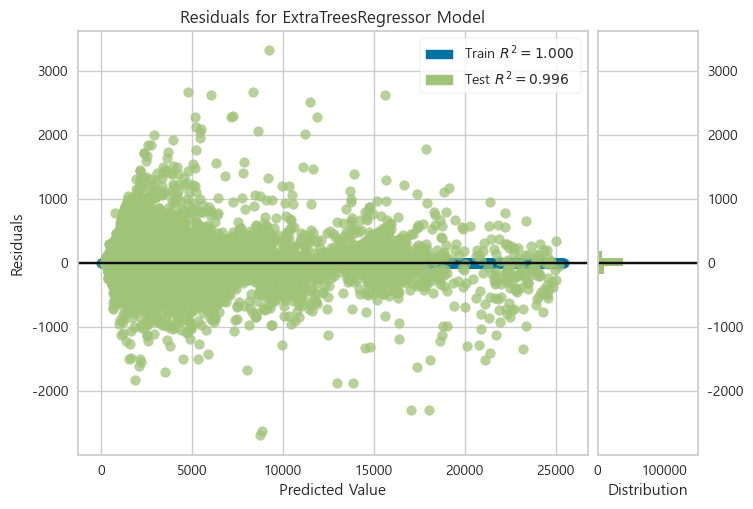

In [42]:
# plot residuals
plot_model(best, plot = 'residuals')

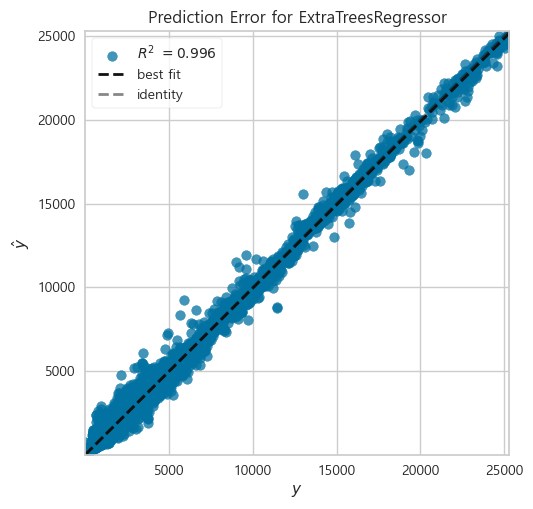

In [43]:
# plot error
plot_model(best, plot = 'error')

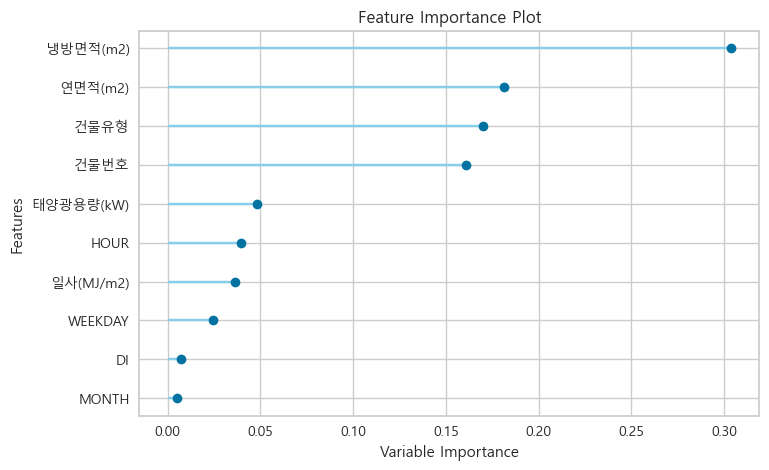

In [44]:
# plot feature importance
plot_model(best, plot = 'feature')

In [45]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
# predict on test set
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,80.1319,23592.8457,153.5996,0.9961,0.0836,0.0794


In [47]:
# show predictions df
holdout_pred.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),YEAR,MONTH,DAY,...,DI,DI_CAT,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),전력소비량(kWh),prediction_label
149403,74,22.100000,0.0,2.5,92.0,0.0,0.00,2022,6,21,...,71.173683,2,8,253743.000000,142705.0,621.000000,0.0,0.0,3015.360107,3085.055989
166072,82,29.900000,0.0,3.6,70.0,1.0,2.44,2022,7,5,...,81.229698,3,9,225651.000000,114772.0,0.000000,0.0,0.0,5099.040039,4906.824004
119010,59,26.000000,0.1,2.4,93.0,0.0,0.25,2022,6,29,...,77.999199,2,6,105500.718750,84402.0,0.000000,0.0,0.0,2347.560059,2479.587605
93481,46,27.700001,0.0,1.8,77.0,0.0,0.00,2022,8,10,...,78.841713,0,5,85869.492188,78675.0,100.559998,0.0,0.0,1663.920044,1840.473569
156425,77,32.599998,0.0,3.2,58.0,0.6,1.18,2022,7,28,...,83.130920,3,9,67377.140625,1.0,0.000000,0.0,0.0,2292.840088,2188.288804


In [48]:
# copy data and drop charges

new_data = train_df.copy()
new_data.drop('전력소비량(kWh)', axis=1, inplace=True)
new_data.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),YEAR,MONTH,DAY,HOUR,WEEKDAY,DI,DI_CAT,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,18.6,0.0,0.9,42.0,0.0,0.0,2022,6,1,0,2,63.09388,1,0,110634.0,39570.0,0.0,0.0,0.0
1,1,18.0,0.0,1.1,45.0,0.0,0.0,2022,6,1,1,2,62.46400,1,0,110634.0,39570.0,0.0,0.0,0.0
2,1,17.7,0.0,1.5,45.0,0.0,0.0,2022,6,1,2,2,62.08735,1,0,110634.0,39570.0,0.0,0.0,0.0
3,1,16.7,0.0,1.4,48.0,0.0,0.0,2022,6,1,3,2,60.89884,1,0,110634.0,39570.0,0.0,0.0,0.0
4,1,18.4,0.0,2.8,43.0,0.0,0.0,2022,6,1,4,2,62.88788,1,0,110634.0,39570.0,0.0,0.0,0.0


In [49]:
# predict model on new_data
predictions = predict_model(best, data = new_data)
predictions.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),YEAR,MONTH,DAY,...,WEEKDAY,DI,DI_CAT,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),prediction_label
0,1,18.600000,0.0,0.9,42.0,0.0,0.0,2022,6,1,...,2,63.093880,1,0,110634.0,39570.0,0.0,0.0,0.0,1085.280029
1,1,18.000000,0.0,1.1,45.0,0.0,0.0,2022,6,1,...,2,62.464001,1,0,110634.0,39570.0,0.0,0.0,0.0,1047.359985
2,1,17.700001,0.0,1.5,45.0,0.0,0.0,2022,6,1,...,2,62.087349,1,0,110634.0,39570.0,0.0,0.0,0.0,978.830399
3,1,16.700001,0.0,1.4,48.0,0.0,0.0,2022,6,1,...,2,60.898842,1,0,110634.0,39570.0,0.0,0.0,0.0,953.760010
4,1,18.400000,0.0,2.8,43.0,0.0,0.0,2022,6,1,...,2,62.887878,1,0,110634.0,39570.0,0.0,0.0,0.0,986.400024


In [106]:
# save pipeline
save_model(best, 'my_first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['건물번호', '기온(C)', '강수량(mm)',
                                              '풍속(m/s)', '습도(%)', '일조(hr)',
                                              '일사(MJ/m2)', 'YEAR', 'MONTH',
                                              'DAY', 'HOUR', 'WEEKDAY', 'DI',
                                              'DI_CAT', '건물유형', '연면적(m2)',
                                              '냉방면적(m2)', '태양광용량(kW)',
                                              'ESS저장용량(kWh)', 'PCS용량(kW)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('trained_model',

In [50]:
# train a dt model with default params
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,82.4743,25331.4884,159.1587,0.9957,0.0860,0.0465
1,83.6430,27136.1856,164.7306,0.9955,0.0880,0.0468
2,83.3265,29928.3183,172.9980,0.9952,0.0820,0.0450
3,82.6352,26024.9418,161.3225,0.9955,0.0818,0.0453
4,81.7447,24269.1852,155.7857,0.9959,0.0799,0.0449
5,81.9572,26938.0408,164.1281,0.9953,0.0783,0.0443
6,81.4220,23216.3412,152.3691,0.9961,0.0774,0.0445
7,82.7672,26710.4763,163.4334,0.9952,0.0814,0.0454
8,80.7680,24680.3613,157.0998,0.9959,0.1003,0.0445


In [ ]:
# tune hyperparameters of dt
tuned_et = tune_model(et)